# Daily historical stock prices from 1970 - 2018

Link to data: https://www.kaggle.com/ehallmar/daily-historical-stock-prices-1970-2018/data#_=_

## Read csv files

Kaggle data sets are downloaded to my local disk. Now we use pandas to read the csv files.

In [2]:
import os
import pandas as pd
import numpy as np

os.getcwd

rdat_price = pd.read_csv(os.getcwd() + '/daily-historical-stock-prices-1970-2018/historical_stock_prices.csv')
rdat_names = pd.read_csv(os.getcwd() + '/daily-historical-stock-prices-1970-2018/historical_stocks.csv')

## Explore the data sets

To explore what kind of data sets we have, I took a look at the first few rows of both the data sets. Data descriptions are also available in the links. However, let's take a real look on what kind of data we have, and how "clean" the data set is.

In [16]:
print(rdat_price.head(), rdat_names.head())
print(rdat_price.columns, rdat_names.columns)

  ticker   open  close  adj_close    low   high   volume        date
0    AHH  11.50  11.58   8.493155  11.25  11.68  4633900  2013-05-08
1    AHH  11.66  11.55   8.471151  11.50  11.66   275800  2013-05-09
2    AHH  11.55  11.60   8.507822  11.50  11.60   277100  2013-05-10
3    AHH  11.63  11.65   8.544494  11.55  11.65   147400  2013-05-13
4    AHH  11.60  11.53   8.456484  11.50  11.60   184100  2013-05-14   ticker exchange                                    name             sector  \
0    PIH   NASDAQ  1347 PROPERTY INSURANCE HOLDINGS, INC.            FINANCE   
1  PIHPP   NASDAQ  1347 PROPERTY INSURANCE HOLDINGS, INC.            FINANCE   
2   TURN   NASDAQ                180 DEGREE CAPITAL CORP.            FINANCE   
3   FLWS   NASDAQ                 1-800 FLOWERS.COM, INC.  CONSUMER SERVICES   
4   FCCY   NASDAQ           1ST CONSTITUTION BANCORP (NJ)            FINANCE   

                     industry  
0  PROPERTY-CASUALTY INSURERS  
1  PROPERTY-CASUALTY INSURERS  
2  FINANC

From a brief view, it looks like the data set is pretty clean!

It seems that in the historical stock price data set, we have the stock code, opening price, closing price, adjusted closing price, lowest price of the day, highest prices of the day, volume (of sales?). On the historical stocks data set, we have the stock code, name of the exchange site, name of the company, sector, and industry. 

On a small note, I want to make sure that my date variable is set as a datetime64 type in Python. Let's convert it below.

In [31]:
import datetime

rdat_price['date'] = rdat_price.date.astype('datetime64')

Currently, I'm wondering how many stocks/time series am I looking to analyze... let's take a look.

In [ ]:
unique_ticker = rdat_price.ticker.unique()
unique_ticker.size

There are a total of 5685 unique stocks (tickers) to look at. 

Let's see how many sectors are in this data set?

In [243]:
unique_sector = rdat_names.sector.unique()
print(unique_sector)

print(rdat_names[pd.isnull(rdat_names.sector)])
print(rdat_names[rdat_names.sector == 'SECTOR'])
rdat_names = rdat_names[rdat_names.sector != 'SECTOR'] # removing this since it might've been a mistake add=on

['FINANCE' 'CONSUMER SERVICES' 'TECHNOLOGY' 'PUBLIC UTILITIES'
 'CAPITAL GOODS' 'BASIC INDUSTRIES' 'HEALTH CARE' 'CONSUMER DURABLES' nan
 'ENERGY' 'MISCELLANEOUS' 'SECTOR' 'TRANSPORTATION'
 'CONSUMER NON-DURABLES']
     ticker exchange                                               name  \
19      ABP   NASDAQ                                  ABPRO CORPORATION   
42     SQZZ   NASDAQ                         ACTIVE ALTS CONTRARIAN ETF   
62      ACT   NASDAQ                             ADVISORSHARES VICE ETF   
100    ABDC   NASDAQ                             ALCENTRA CAPITAL CORP.   
124    SMCP   NASDAQ           ALPHAMARK ACTIVELY MANAGED SMALL CAP ETF   
...     ...      ...                                                ...   
6393    WIA     NYSE  WESTERN ASSET/CLAYMORE U.S. TREASURY INFLATION...   
6431   XFLT     NYSE  XAI OCTAGON FLOATING RATE & ALTERNATIVE INCOME...   
6451   ZB^A     NYSE                               ZIONS BANCORPORATION   
6452   ZB^G     NYSE               

There are a total of 13 sectors. One sector is nan but there are no tickers within the sector. The other category which is 'SECTOR' has no tickers there either. We will remove the two

In [ ]:
print(rdat_names[rdat.sector == 'SECTOR'])

## Plotting time series

Let's take a look at the plots for data exploration 

In [248]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

def plot_tickers(ticker_names, start=0, finish=4):

    fig = plt.figure(figsize = (20,10))
    fig = fig.add_subplot(111)

    lines_legend = []
    labels_legend = []

    for i in ticker_names[start:finish]:
        price_to_plot = rdat_price[rdat_price.ticker == i]
        l = fig.plot(price_to_plot.date, price_to_plot.close, label = i)    
        lines_legend.append(l)
        labels_legend.append(i)
    
    fig.legend(lines_legend,     # The line objects
               labels=labels_legend,   # The labels for each line
               loc="center right",   # Position of legend
               borderaxespad=0.1,    # Small spacing around legend box
               title="Legend Title"  # Title for the legend
               )

/Users/lisa/.conda/envs/ubc_ketos/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


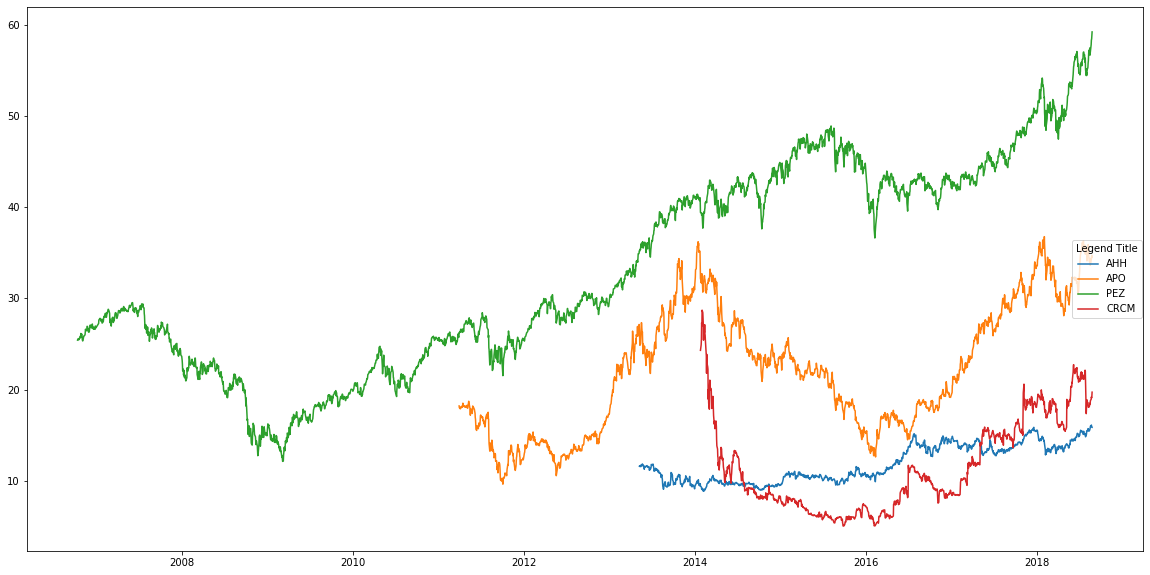

In [249]:
plot_tickers(unique_ticker,0,4)

From the plot, we see that the time series from each stock starts from various times. This could be a problem in terms of Python's pandas and numpy objects since it will call the missing data points as "nan"s. Running scikit-learn's kmeans algorithm cannot contain "nan"s due to the source code for the package. Hence, I decide to use tslearn to handle the missing lengths among the time series data.

Note to self: let's see if tslearn has LOF so that it can handle LOF data as well.

# Data manipulation

From exploration, we know that there are a few outcomes available in the Kaggle competition. Currently, I am only interested in univariate modellings first since I'd like to start with something small and simple. My goal ultimately is to understand which outcomes (or a combination of them) affect unsupervised learning methods.

Below, I've used a few data manipulation techniques such as filters and pivots from the raw data and created a few desired plots for data illustration.

Let's take a look at the adjusted closing price.

In [300]:
# Pivot from rdat_price to data structure that fits for kmeans

import numpy as np
from tslearn.utils import to_time_series_dataset

def pivot_kmeans(rdat_price, value = 'adj_close'):
    data_close = rdat_price.pivot(index='date', columns='ticker', values=value)
    # pivot rdat based on adj_close values (long to wide)
    
    ticker = data_close.columns
    
    data_close_T = data_close.transpose() 
    data_close_list = data_close_T.values.tolist() 
    # convert it to a list so we can use tslearn.utils.to_time_series_dataset

    data_close_list_no_na = [[z_ij for z_ij in z_i if ~np.isnan(z_ij)] for z_i in data_close_list]
    # get rid of nan values in nested lists

    X_bis = to_time_series_dataset(data_close_list_no_na) 
    # convert to time series data set
    
    return X_bis, ticker

For the purposes of simplicity, I would like to investigate how well the kmeans clustering is in terms of sector. I will randomly sample ten time series from each sector and apply the kmeans clustering. Let's see what happens when we run kmeans clustering on adjusted closing price.

Note that I removed stocks that have empty sectors - let's focus on stocks that have clear sector labels.

In [244]:
import random

unique_sector = rdat_names.sector.unique()

seg_rdat = pd.DataFrame([]) #taking meta data from randomized tickers

for i in unique_sector[~pd.isnull(unique_sector)]:
    per_sector = rdat_names[rdat_names.sector == i] # filter out each sector
    random.seed(i)
    rand_generated = random.sample(range(per_sector.shape[0]), 10) # obtain indices of 10 from each sector
    X_bis_10 = per_sector.iloc[rand_generated] # obtain 10 random samples
    seg_rdat = seg_rdat.append(X_bis_10)
    
seg_price = rdat_price[rdat_price.ticker.isin(seg_rdat.ticker)] # taking whole data set of the randomized tickers

Let's take a look at the randomly chosen stocks under FINANCE.

/Users/lisa/.conda/envs/ubc_ketos/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


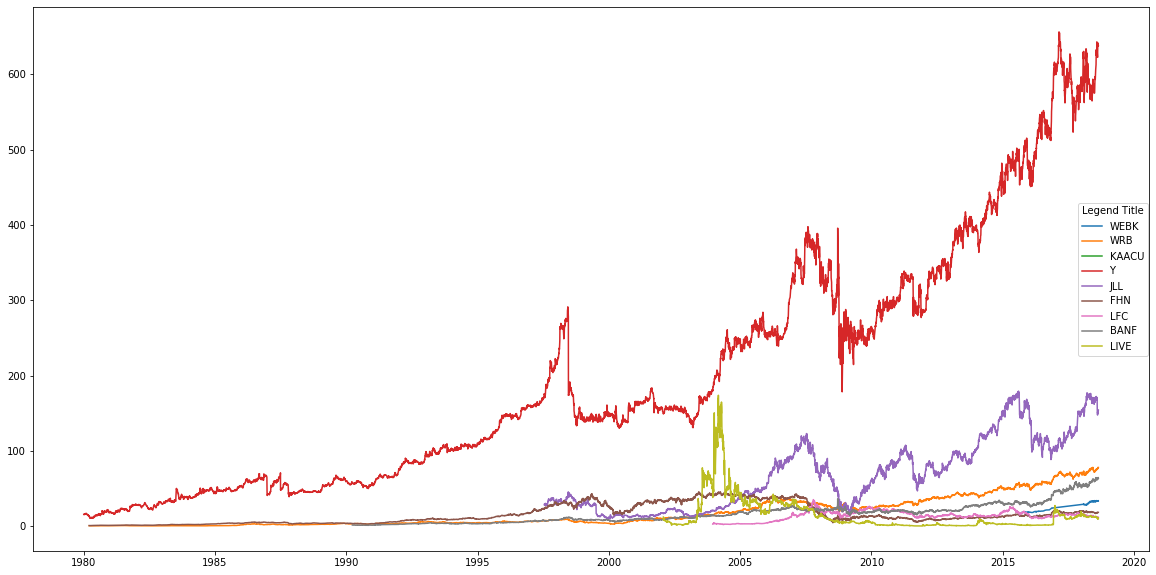

In [267]:
fin_tickers = seg_rdat.ticker[seg_rdat.sector == 'FINANCE']
plot_tickers(fin_tickers.values, 0, 9)

Let's look at some randomly chosen tickers for HEALTH CARE

/Users/lisa/.conda/envs/ubc_ketos/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


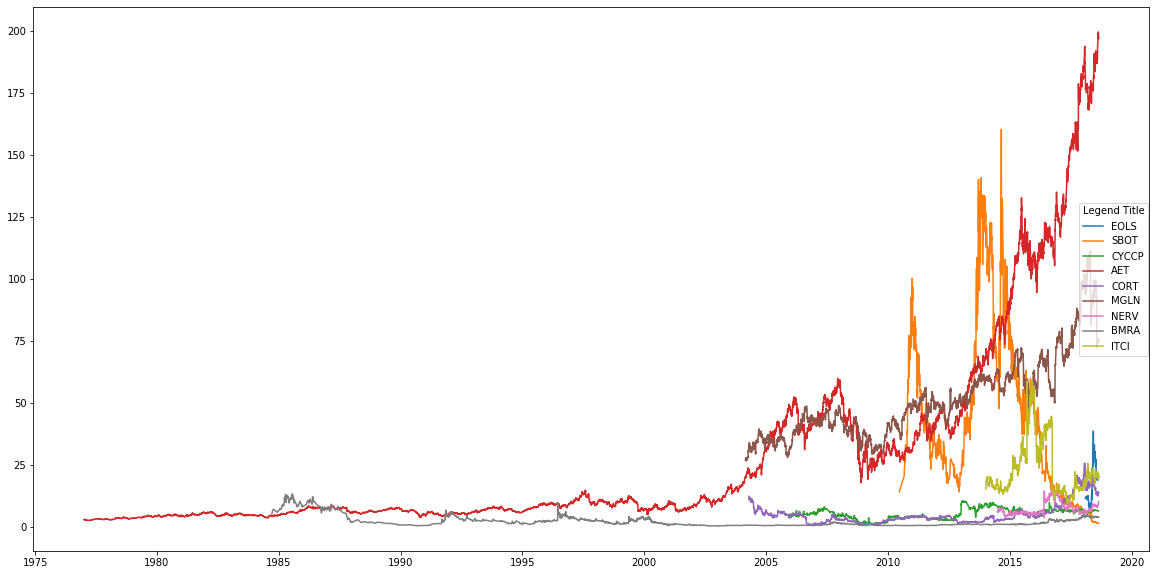

In [268]:
fin_tickers = seg_rdat.ticker[seg_rdat.sector == 'HEALTH CARE']
plot_tickers(fin_tickers.values, 0, 9)

In [301]:
from tslearn.clustering import TimeSeriesKMeans

# Note that we will not be using euclidean as metric since the time series are of unequal length.
# Hence, we will be using dynamic time warping as a metric.

X, seg_ticker = pivot_kmeans(seg_price)

km_dba = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=5,
                           max_iter_barycenter=5,
                           random_state=0).fit_predict(X)
km_dba

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1])

/Users/lisa/.conda/envs/ubc_ketos/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


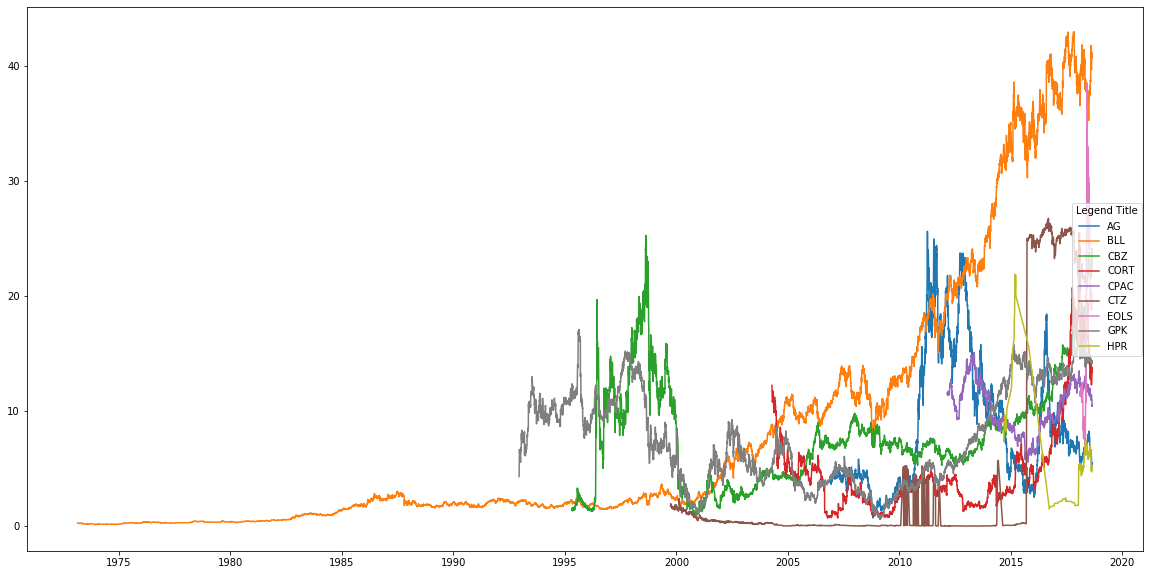

In [302]:
# Plotting 10 of the time series within cluster of 0

plot_tickers(seg_ticker.values[km_dba==0], 0, 9)

/Users/lisa/.conda/envs/ubc_ketos/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


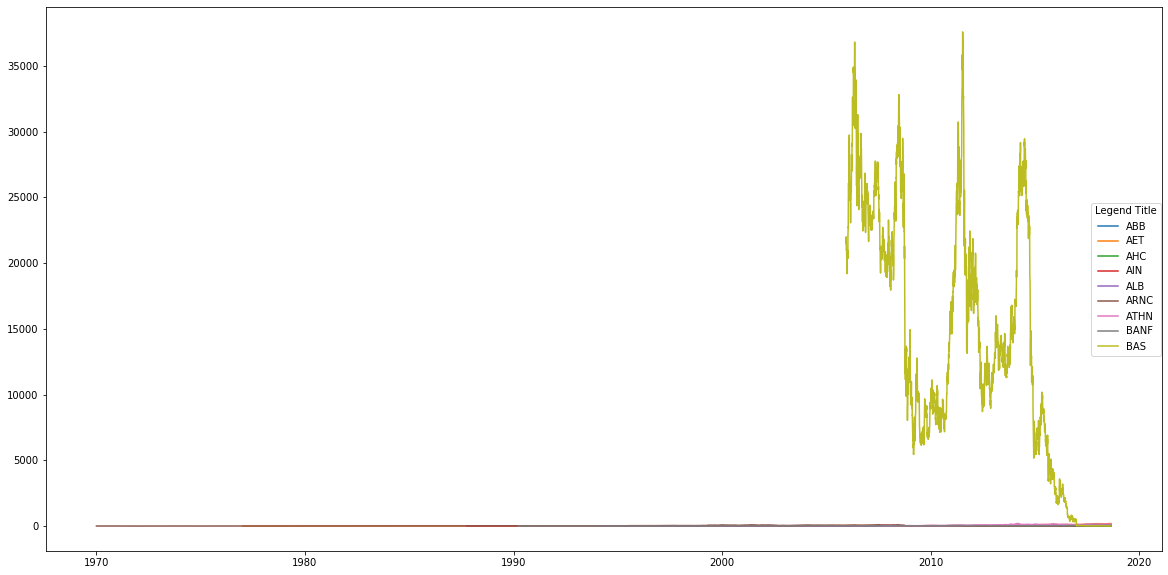

In [308]:
# Plotting 10 of the time series within cluster of 1

plot_tickers(seg_ticker.values[km_dba==1], 0, 9)

Notice that the ticker for BAS reaches at $35000 closing price (suspicious!). At the moment, we will remove BAS because it "overpowered" the other stocks that share a smaller scale in the y-axis.

/Users/lisa/.conda/envs/ubc_ketos/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


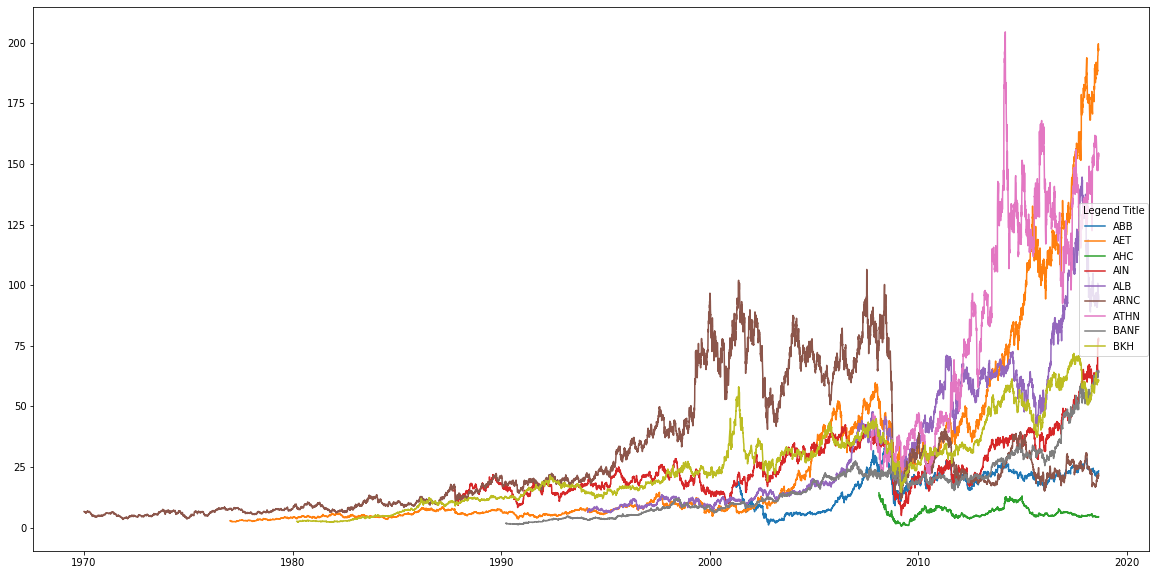

In [307]:
# Plotting 10 of the time series within cluster of 1 - removed BAS

temp_tickers = seg_ticker.values[km_dba==1]
temp_tickers = temp_tickers[temp_tickers != 'BAS'] # BAS 
temp_tickers
plot_tickers(temp_tickers, 0, 9)

The graph now looks better. Let's see what the differences are between these plots:

From graph on the second cluster (of cluster = 1), it seemed that the k-means clustering algorithm clustered stocks which were increasing at a gradual rate and maintained the stock prices until the sudden drop in year 2009. The stocks then bounced back and increased drastically after the drop. However, I do not see the resemblence of BAS stock in comparison to the other stocks. Perhaps the 

On the first cluster, it is hard to decipher the similarities between the stocks. Perhaps k-means clustering is not the best algorithm to understand 

In [309]:
km_sdtw = TimeSeriesKMeans(n_clusters=3, metric="softdtw", max_iter=5,
                            max_iter_barycenter=5,
                            metric_params={"gamma": .5},
                            random_state=0).fit_predict(X)
km_sdtw

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1])

In [314]:
pd.crosstab(index=np.add(km_sdtw, km_dba),  # Make a crosstab
                      columns="count") 

col_0,count
row_0,
0,27
2,88


It seems like the crosstab shows that the results are the same using softdtw and dtw for measures in clustering.